In [1]:
import os
os.chdir('../')

import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style='darkgrid', palette='muted')

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

import shap

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import wandb

run = wandb.init(
    project='leuko-ml',
    name='svc_analysis',
    job_type='download model',
    config={'model': 'knn'} 
)
artifact = run.use_artifact('ernestoserize-constructor-university/leuko-ml/knn:v0', type='model')
artifact_dir = artifact.download()

wandb.finish()

In [2]:
with open('artifacts/knn:v0/knn.pkl', 'rb') as file:
    knn = pkl.load(file)

In [3]:
data = pd.read_csv('artifacts/acute-stroke-selected:v2/new_data.csv')

In [4]:
X, y = data.drop('discharge_status', axis=1), data['discharge_status']

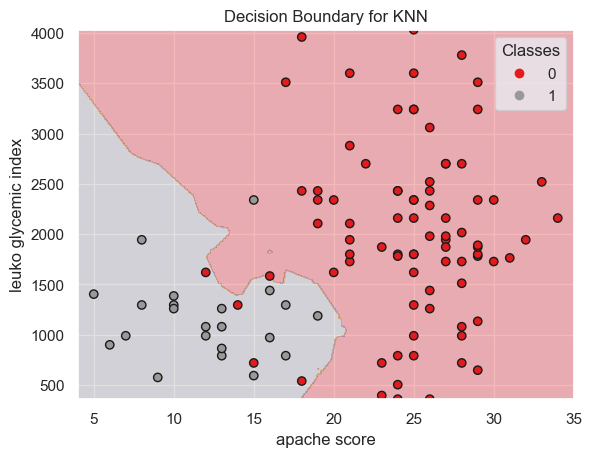

In [5]:
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)

scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')

plt.xlabel('apache score')
plt.ylabel('leuko glycemic index')
plt.title('Decision Boundary for KNN')
plt.legend(*scatter.legend_elements(), title="Classes")

plt.show()

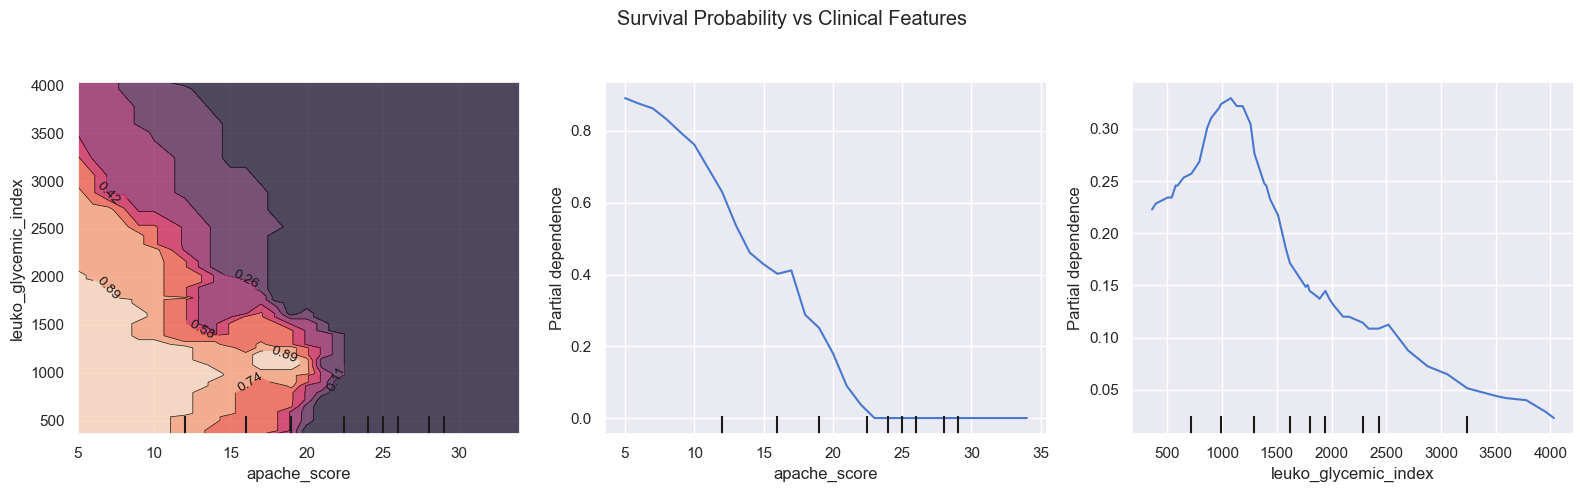

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

features_ = [[(0, 1)],[0],[1]]

for _, i in enumerate(features_):

    PartialDependenceDisplay.from_estimator(
        knn,
        X,
        features=i,
        response_method='predict_proba',
        kind='average',
        grid_resolution=100,
        ax=axes[_]
    )

plt.suptitle('Survival Probability vs Clinical Features')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [33]:
explainer = shap.KernelExplainer(lambda x: knn.predict_proba(x)[:, 1], X)
shap_values = explainer(X)

Using 105 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/105 [00:00<?, ?it/s]

- The baseline, expected survival probability predicted by the model is $ E[f(x)] = 0.213 $. This is due to the imbalance between classes in the data.

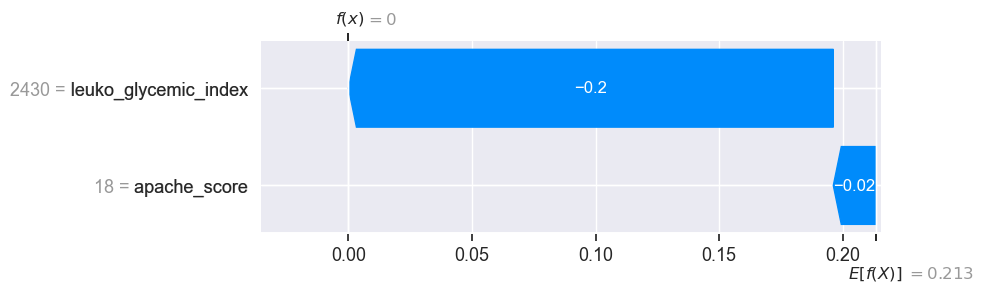

In [8]:
shap.plots.waterfall(shap_values[0])

- For this patient, the predicted survival probability is 0. The leuko-glycemic index (LGI), with a value of 2430, contributes negatively and has a greater influence on the model’s prediction than the Apache score in this case. Notably, the Apache score is below the average, reducing its impact on the final prediction.

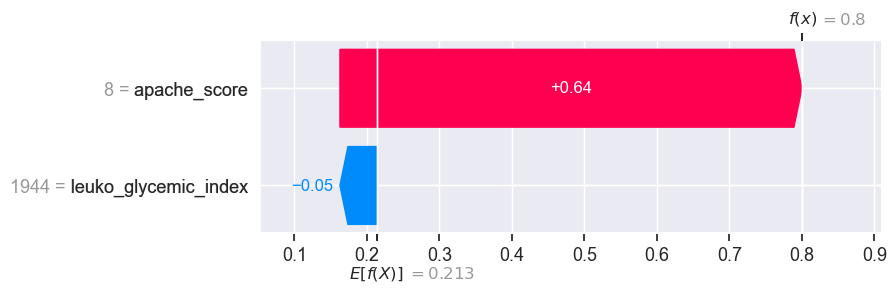

In [32]:
shap.plots.waterfall(shap_values[3])

- The predicted survival probability is 0.8, indicating a strong likelihood of survival. The leuko-glycemic index (LGI), with a value of 1944, has a small negative contribution with minimal impact. The primary factor influencing the prediction is the low Apache score, which boosts the survival probability by approximately 0.64. Despite LGI values above the mean generally lowering the model's output, in this case, the Apache score plays a more decisive role.

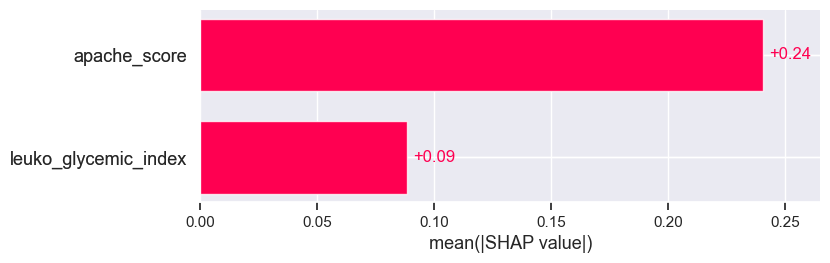

In [10]:
shap.plots.bar(shap_values)

- Overall, the apache_score tends to have a stronger influence on the model’s predictions. From a machine learning perspective, the apache_score may appear to behave like a noisy feature, yet it consistently carries significant weight in the output. Despite this, the leuko-glycemic index (LGI) still contributes to the model’s prediction in a subtle but meaningful way.

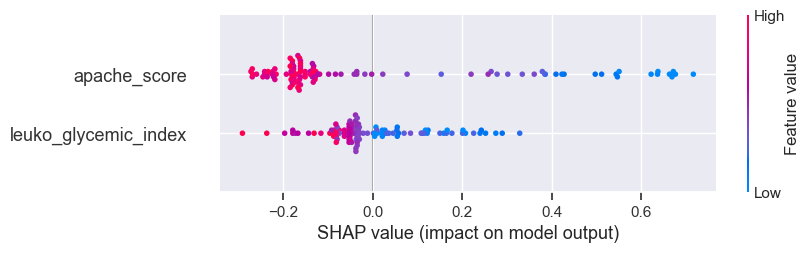

In [11]:
shap.plots.beeswarm(shap_values)

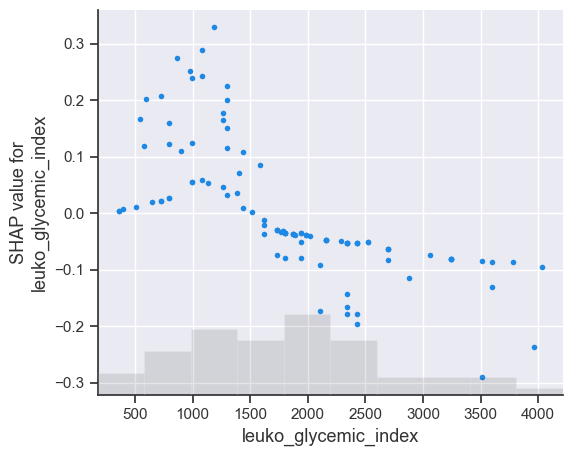

In [12]:
shap.plots.scatter(shap_values[:, 'leuko_glycemic_index'])

### Conclusions

Based on the leuko-glycemic index (LGI) contributions to the model’s predictions, we observe that when the LGI value exceeds approximately 1600–1800, it begins to exert a consistent negative influence on the model’s output. This suggests a threshold effect, where higher LGI values are associated with decreased survival probabilities. While the influence may vary across individuals, the trend indicates that beyond this range, the LGI becomes a more decisive factor in lowering the predicted outcome, reinforcing its importance as a clinical feature in the model’s decision-making process.